In [1]:
import os
import pandas as pd
from mtqe.data.loaders import load_ced_test_data, load_ced_data
from mtqe.utils.paths import EVAL_DIR, PREDICTIONS_DIR
from mtqe.utils.plots import create_histogram_plot, create_calib_plot
from mtqe.utils.language_pairs import LI_LANGUAGE_PAIRS_WMT_21_CED
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve

In [2]:
EXPERIMENT_GROUP_NAME = 'train_monolingual_auth_data'
DATA_SPLIT = 'dev'
THRESHOLD_STRATEGY = 'default'
FILE_SUFFIX = 'median_results.csv'
CHART_NAME = 'Monolingual Authentic Data'

In [3]:
eval_files = [os.path.join(EVAL_DIR, EXPERIMENT_GROUP_NAME, file) for file in os.listdir(os.path.join(EVAL_DIR, EXPERIMENT_GROUP_NAME)) if file.endswith(FILE_SUFFIX)]
enja_separate = False
if os.path.isdir(os.path.join(EVAL_DIR, EXPERIMENT_GROUP_NAME + '_enja')):
    eval_files.extend([os.path.join(EVAL_DIR, EXPERIMENT_GROUP_NAME + '_enja', file) for file in os.listdir(os.path.join(EVAL_DIR, EXPERIMENT_GROUP_NAME + '_enja')) if file.endswith(FILE_SUFFIX)])
    enja_separate = True
    

In [4]:
dfs = []
for file in eval_files:
    df = pd.read_csv(file)
    dfs.append(df)

df_meta_results = pd.concat(dfs)

In [5]:
df_meta_results = df_meta_results[(df_meta_results['threshold_strategy'] == THRESHOLD_STRATEGY) & (df_meta_results['split'] == DATA_SPLIT)]

In [6]:
# Get lists of data to create plot
preds = []
targets = []
indices = []
titles = []
for lp in LI_LANGUAGE_PAIRS_WMT_21_CED:
    seed = df_meta_results[df_meta_results['language_pair']==lp].iloc[0]['seed']
    mcc = df_meta_results[df_meta_results['language_pair']==lp].iloc[0]['MCC']
    precision = df_meta_results[df_meta_results['language_pair']==lp].iloc[0]['precision']
    recall = df_meta_results[df_meta_results['language_pair']==lp].iloc[0]['recall']
    titles.append('Language pair:' + lp)# + '\nMCC:' + str(mcc.round(3)) + '\nPrecision:' + str(precision.round(3)) + '\nRecall:' + str(recall.round(3)))
    threshold = df_meta_results[df_meta_results['language_pair']==lp].iloc[0]['threshold']
    file_prefix = lp + '_' + DATA_SPLIT + '_' + str(seed)
    if lp == 'en-ja' and enja_separate:
        folder = EXPERIMENT_GROUP_NAME + '_enja'
    else:
        folder = EXPERIMENT_GROUP_NAME
    for file in os.listdir(os.path.join(PREDICTIONS_DIR, 'ced_data', folder)):
        if file.startswith(file_prefix) and file.endswith('.csv'):
            # found predictions
            df_preds = pd.read_csv(os.path.join(PREDICTIONS_DIR, 'ced_data', folder, file))
            scores = df_preds['score'].to_numpy()
            scores = 1 - scores
            # binary_scores = scores > threshold
            # binary_scores = binary_scores.astype('int')
            preds.append(scores)
    if DATA_SPLIT == 'test':
        targets.append(1 - load_ced_test_data(lp)['score'].to_numpy())
    else:
        targets.append(1 - load_ced_data(DATA_SPLIT, lp)['score'].to_numpy())
        indices.append(load_ced_data(DATA_SPLIT, lp)['idx'])

In [7]:
load_ced_data(DATA_SPLIT, 'en-cs')['idx']

0      2601
1      2095
2      8392
3      9890
4      6079
       ... 
995    6526
996    1405
997    5517
998    9495
999    3462
Name: idx, Length: 1000, dtype: int64

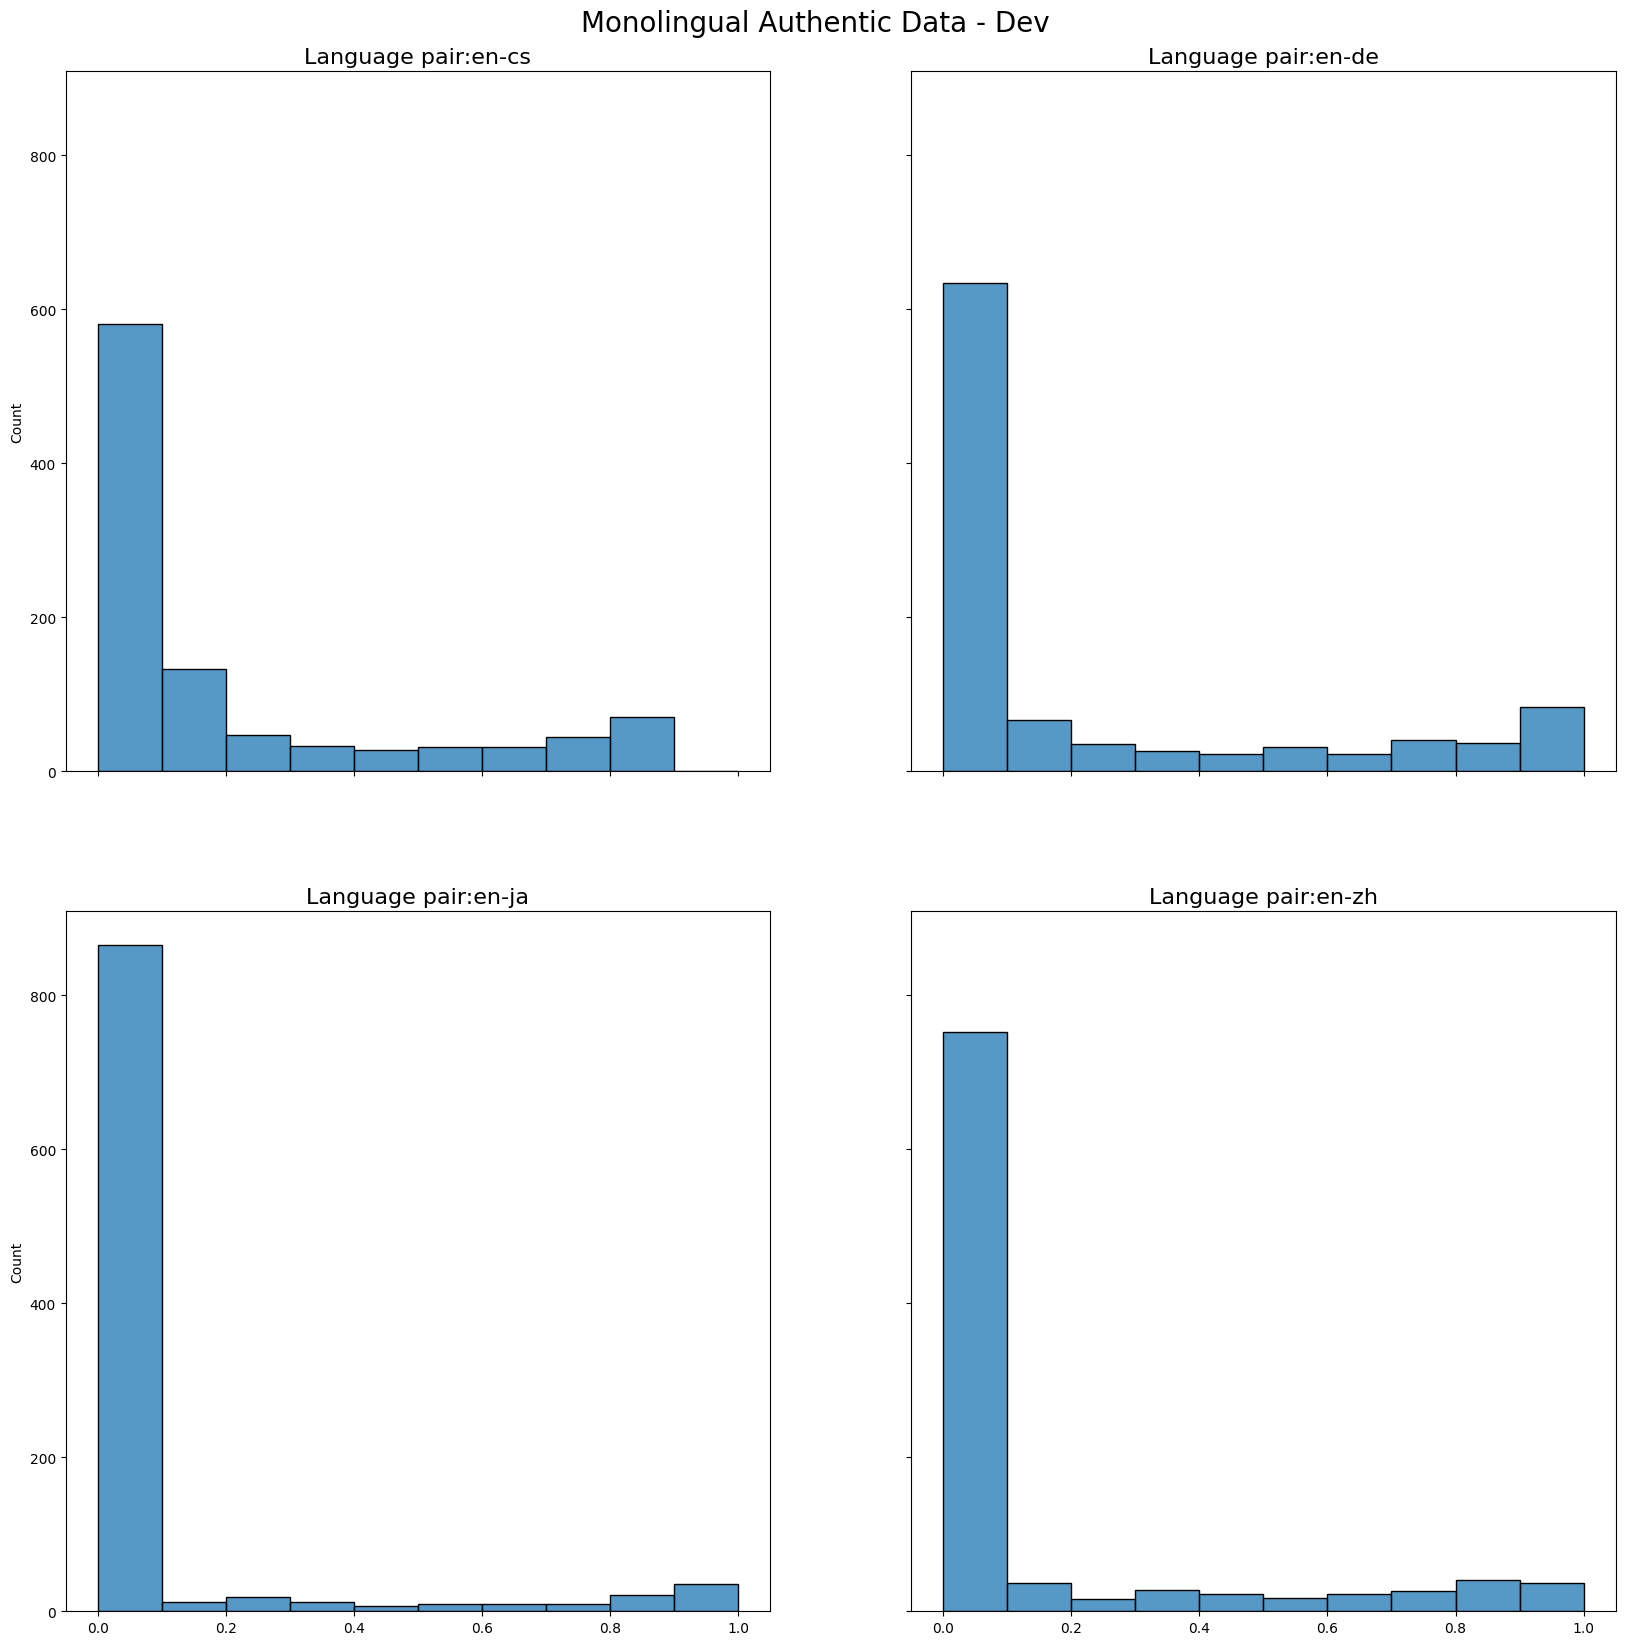

In [24]:
fig = create_histogram_plot(CHART_NAME + ' - Dev', titles, preds)

In [9]:
x_vals = []
y_vals = []
for ind, _ in enumerate(preds):
    y, x = calibration_curve(targets[ind], preds[ind], n_bins=10)
    x_vals.append(x)
    y_vals.append(y)

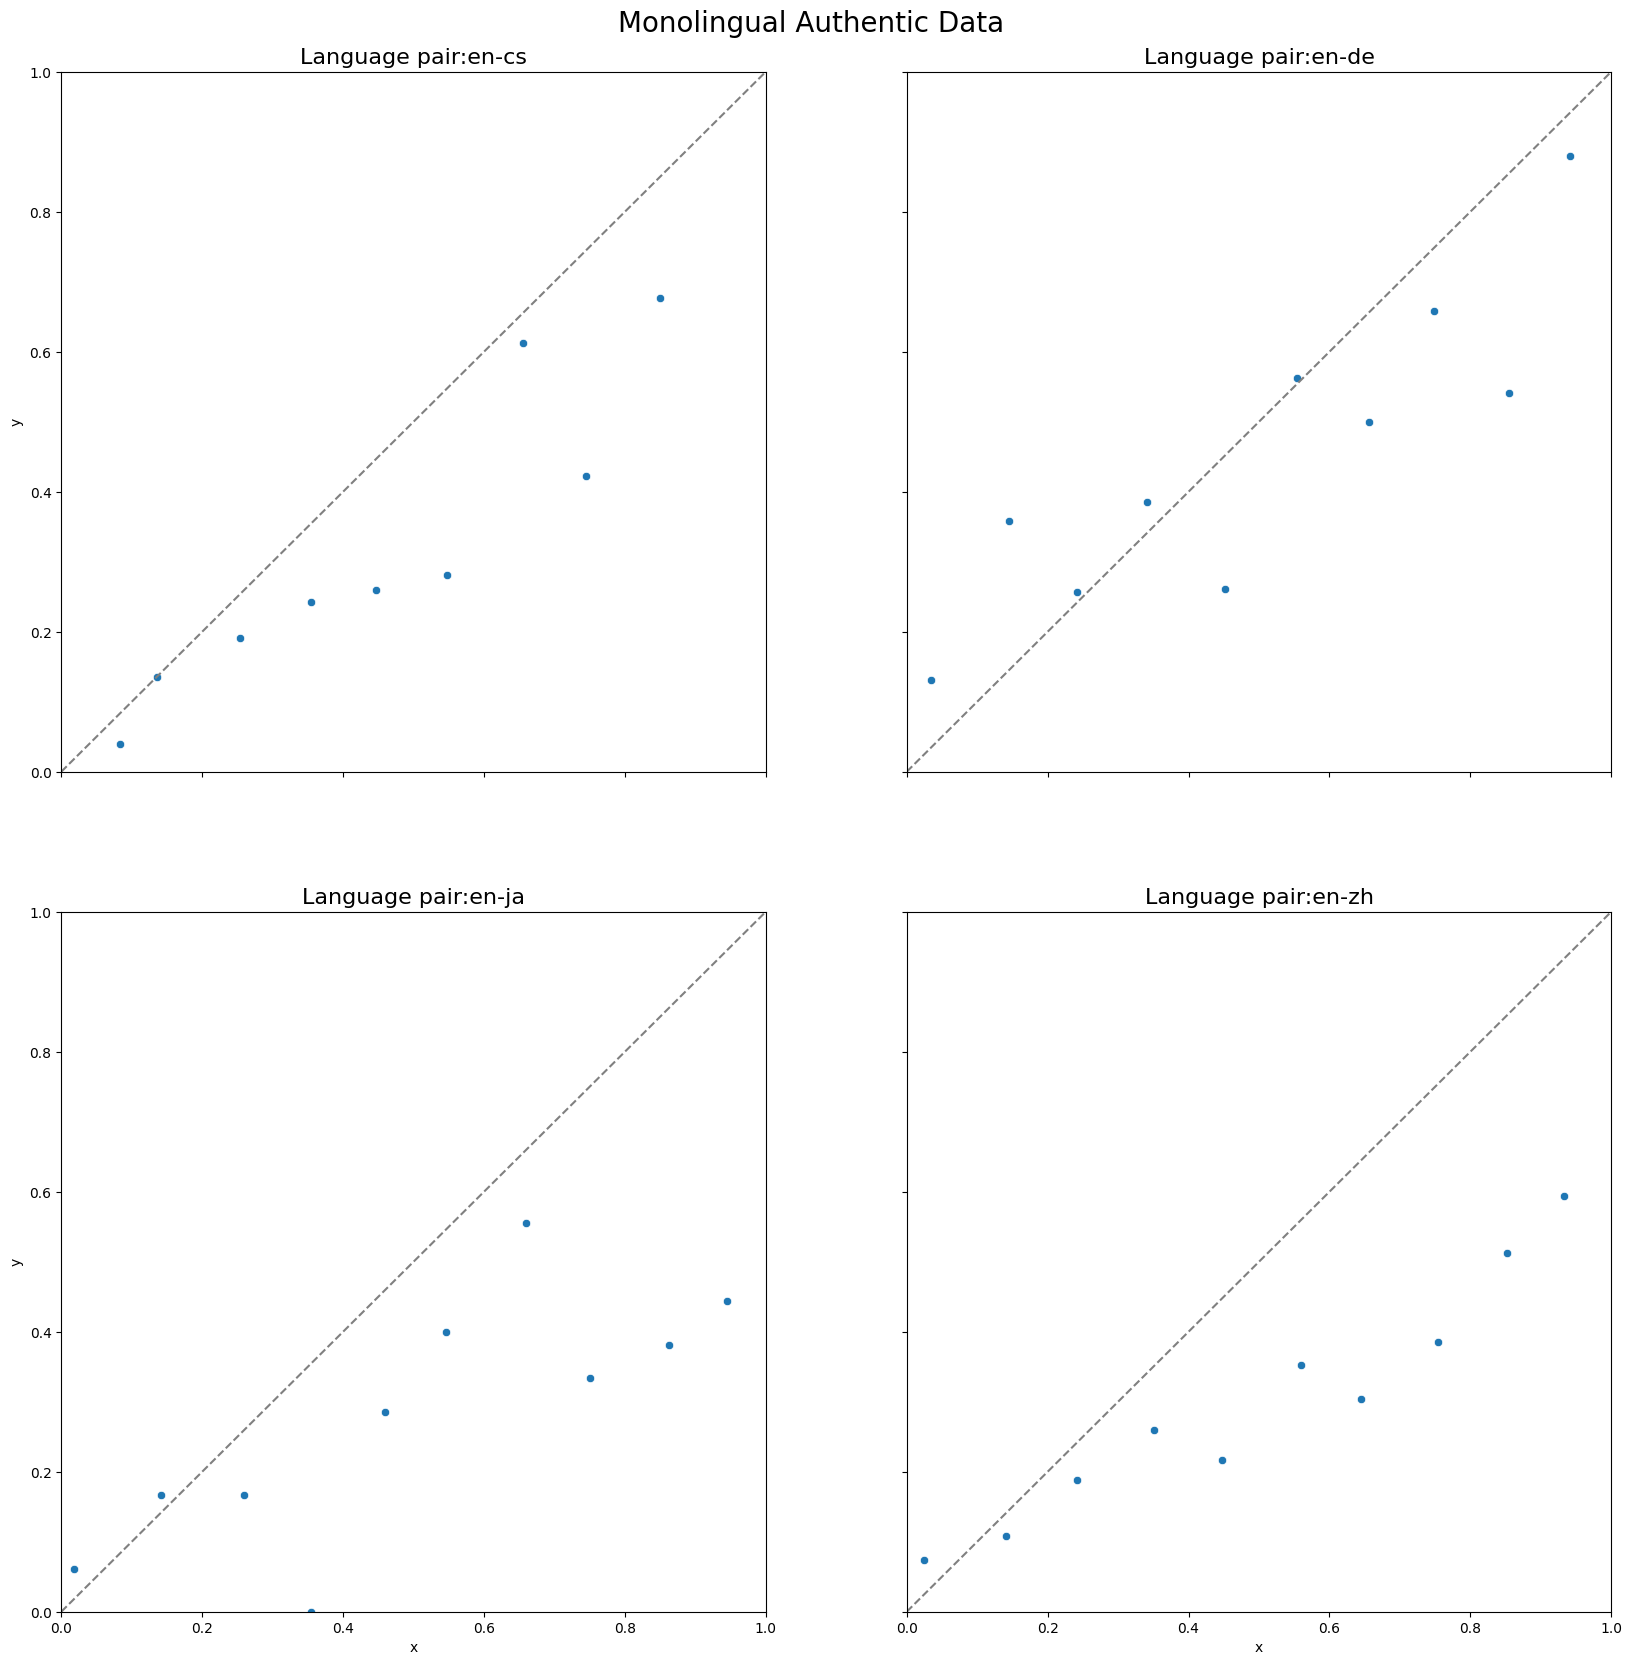

In [10]:
fig = create_calib_plot(CHART_NAME, titles, x_vals, y_vals)

In [11]:
# Get lists of data to create plot
test_preds = []
test_targets = []
test_indices = []
titles = []
for lp in LI_LANGUAGE_PAIRS_WMT_21_CED:
    seed = df_meta_results[df_meta_results['language_pair']==lp].iloc[0]['seed']
    mcc = df_meta_results[df_meta_results['language_pair']==lp].iloc[0]['MCC']
    precision = df_meta_results[df_meta_results['language_pair']==lp].iloc[0]['precision']
    recall = df_meta_results[df_meta_results['language_pair']==lp].iloc[0]['recall']
    titles.append('Language pair:' + lp)# + '\nMCC:' + str(mcc.round(3)) + '\nPrecision:' + str(precision.round(3)) + '\nRecall:' + str(recall.round(3)))
    threshold = df_meta_results[df_meta_results['language_pair']==lp].iloc[0]['threshold']
    file_prefix = lp + '_' + 'test' + '_' + str(seed)
    if lp == 'en-ja' and enja_separate:
        folder = EXPERIMENT_GROUP_NAME + '_enja'
    else:
        folder = EXPERIMENT_GROUP_NAME
    for file in os.listdir(os.path.join(PREDICTIONS_DIR, 'ced_data', folder)):
        if file.startswith(file_prefix) and file.endswith('.csv'):
            # found predictions
            df_preds = pd.read_csv(os.path.join(PREDICTIONS_DIR, 'ced_data', folder, file))
            scores = df_preds['score'].to_numpy()
            scores = 1 - scores
            # binary_scores = scores > threshold
            # binary_scores = binary_scores.astype('int')
            test_preds.append(scores)
    test_targets.append(1 - load_ced_test_data(lp)['score'].to_numpy())
    test_indices.append(load_ced_test_data(lp)['idx'])

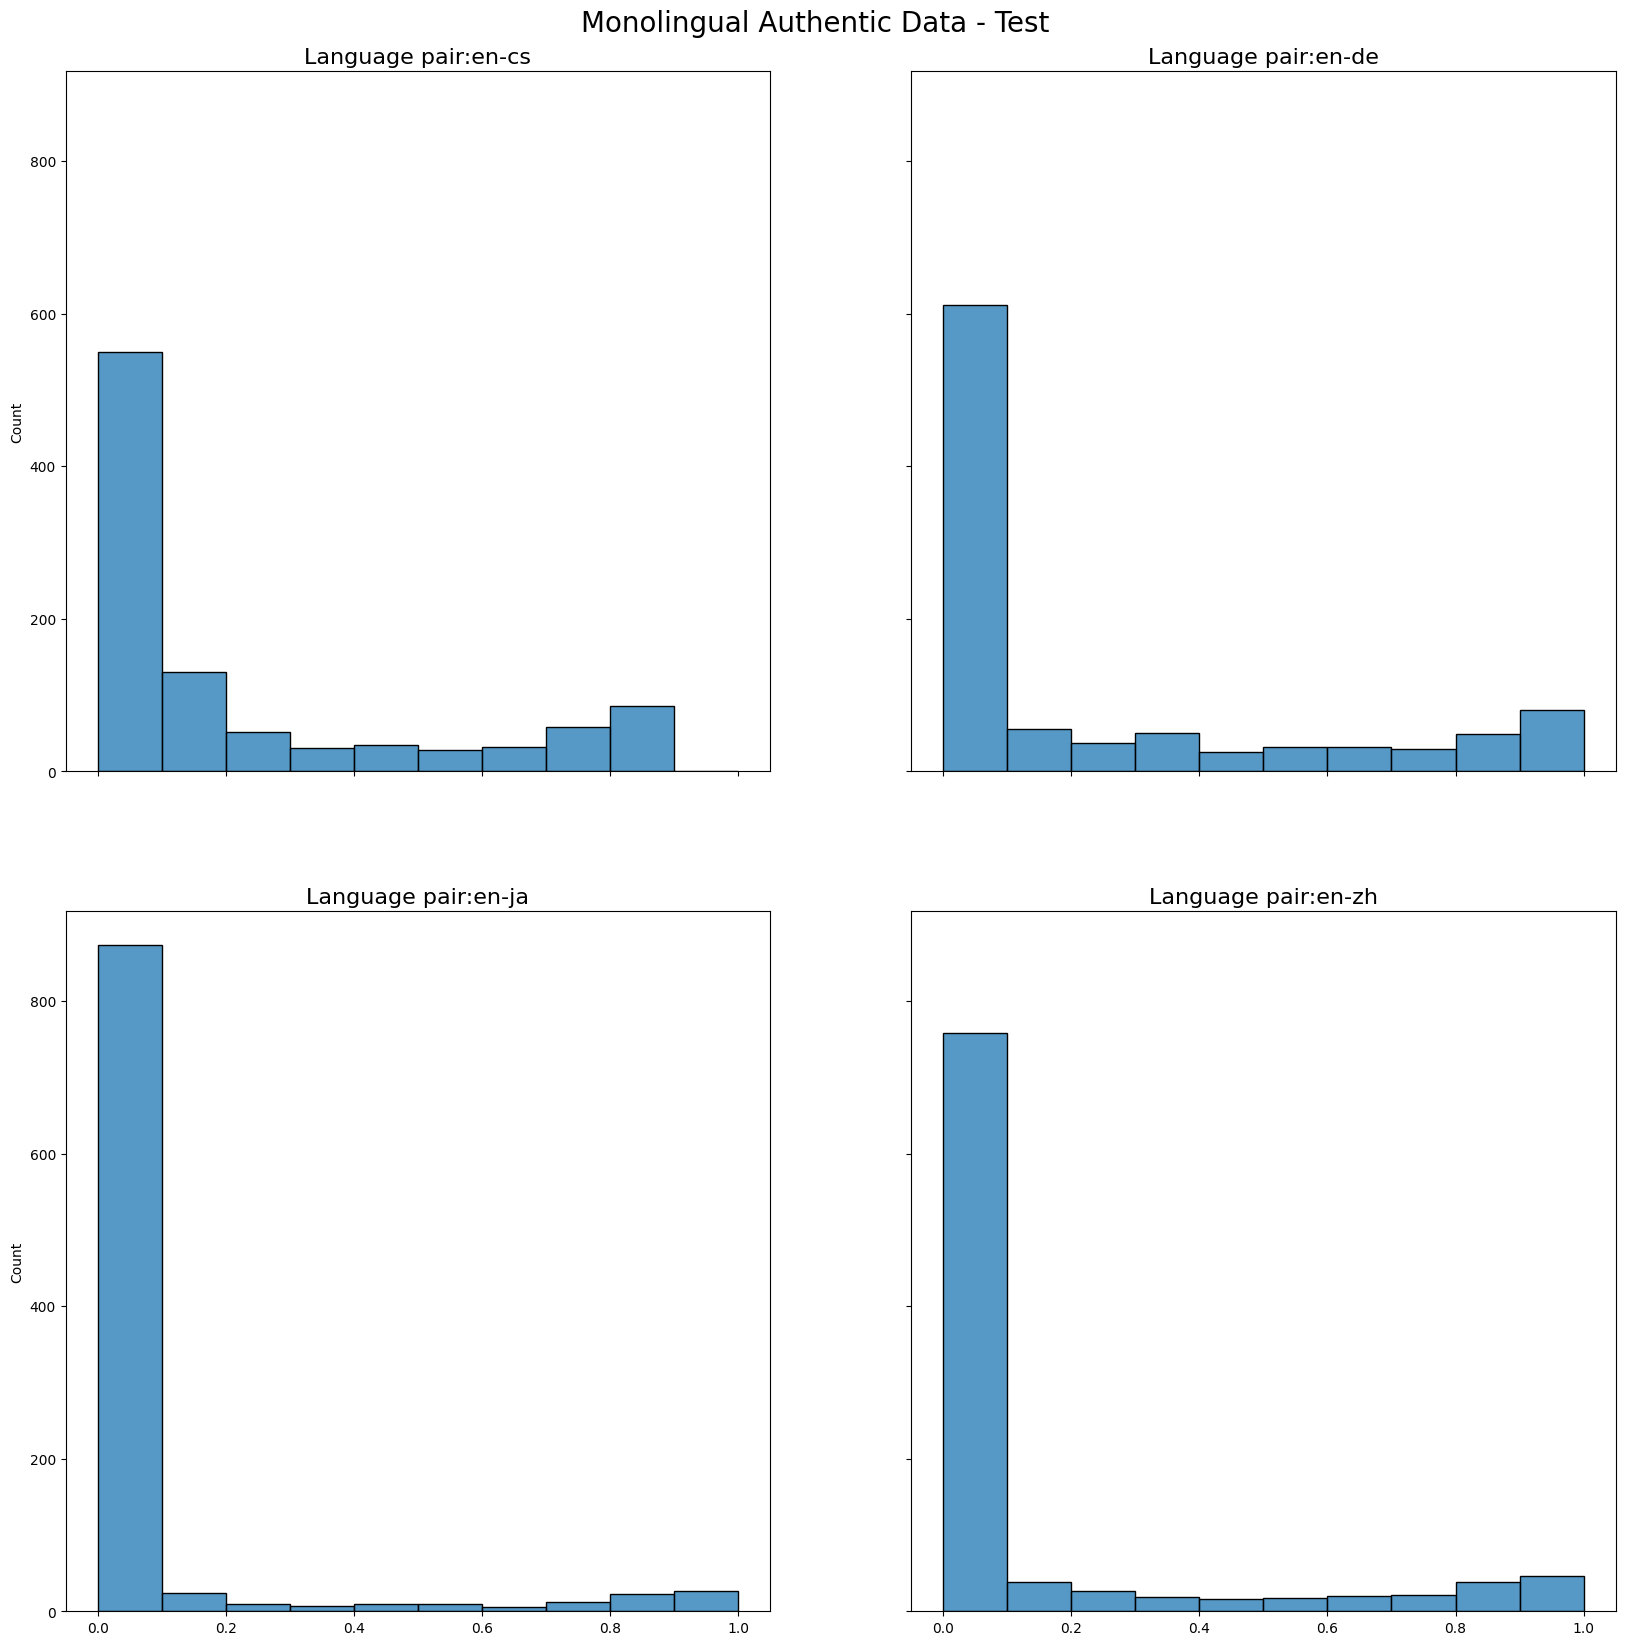

In [23]:
fig = create_histogram_plot(CHART_NAME + ' - Test', titles, test_preds)

In [12]:
x_vals = []
y_vals = []
for ind, _ in enumerate(test_preds):
    y, x = calibration_curve(test_targets[ind], test_preds[ind], n_bins=10)
    x_vals.append(x)
    y_vals.append(y)

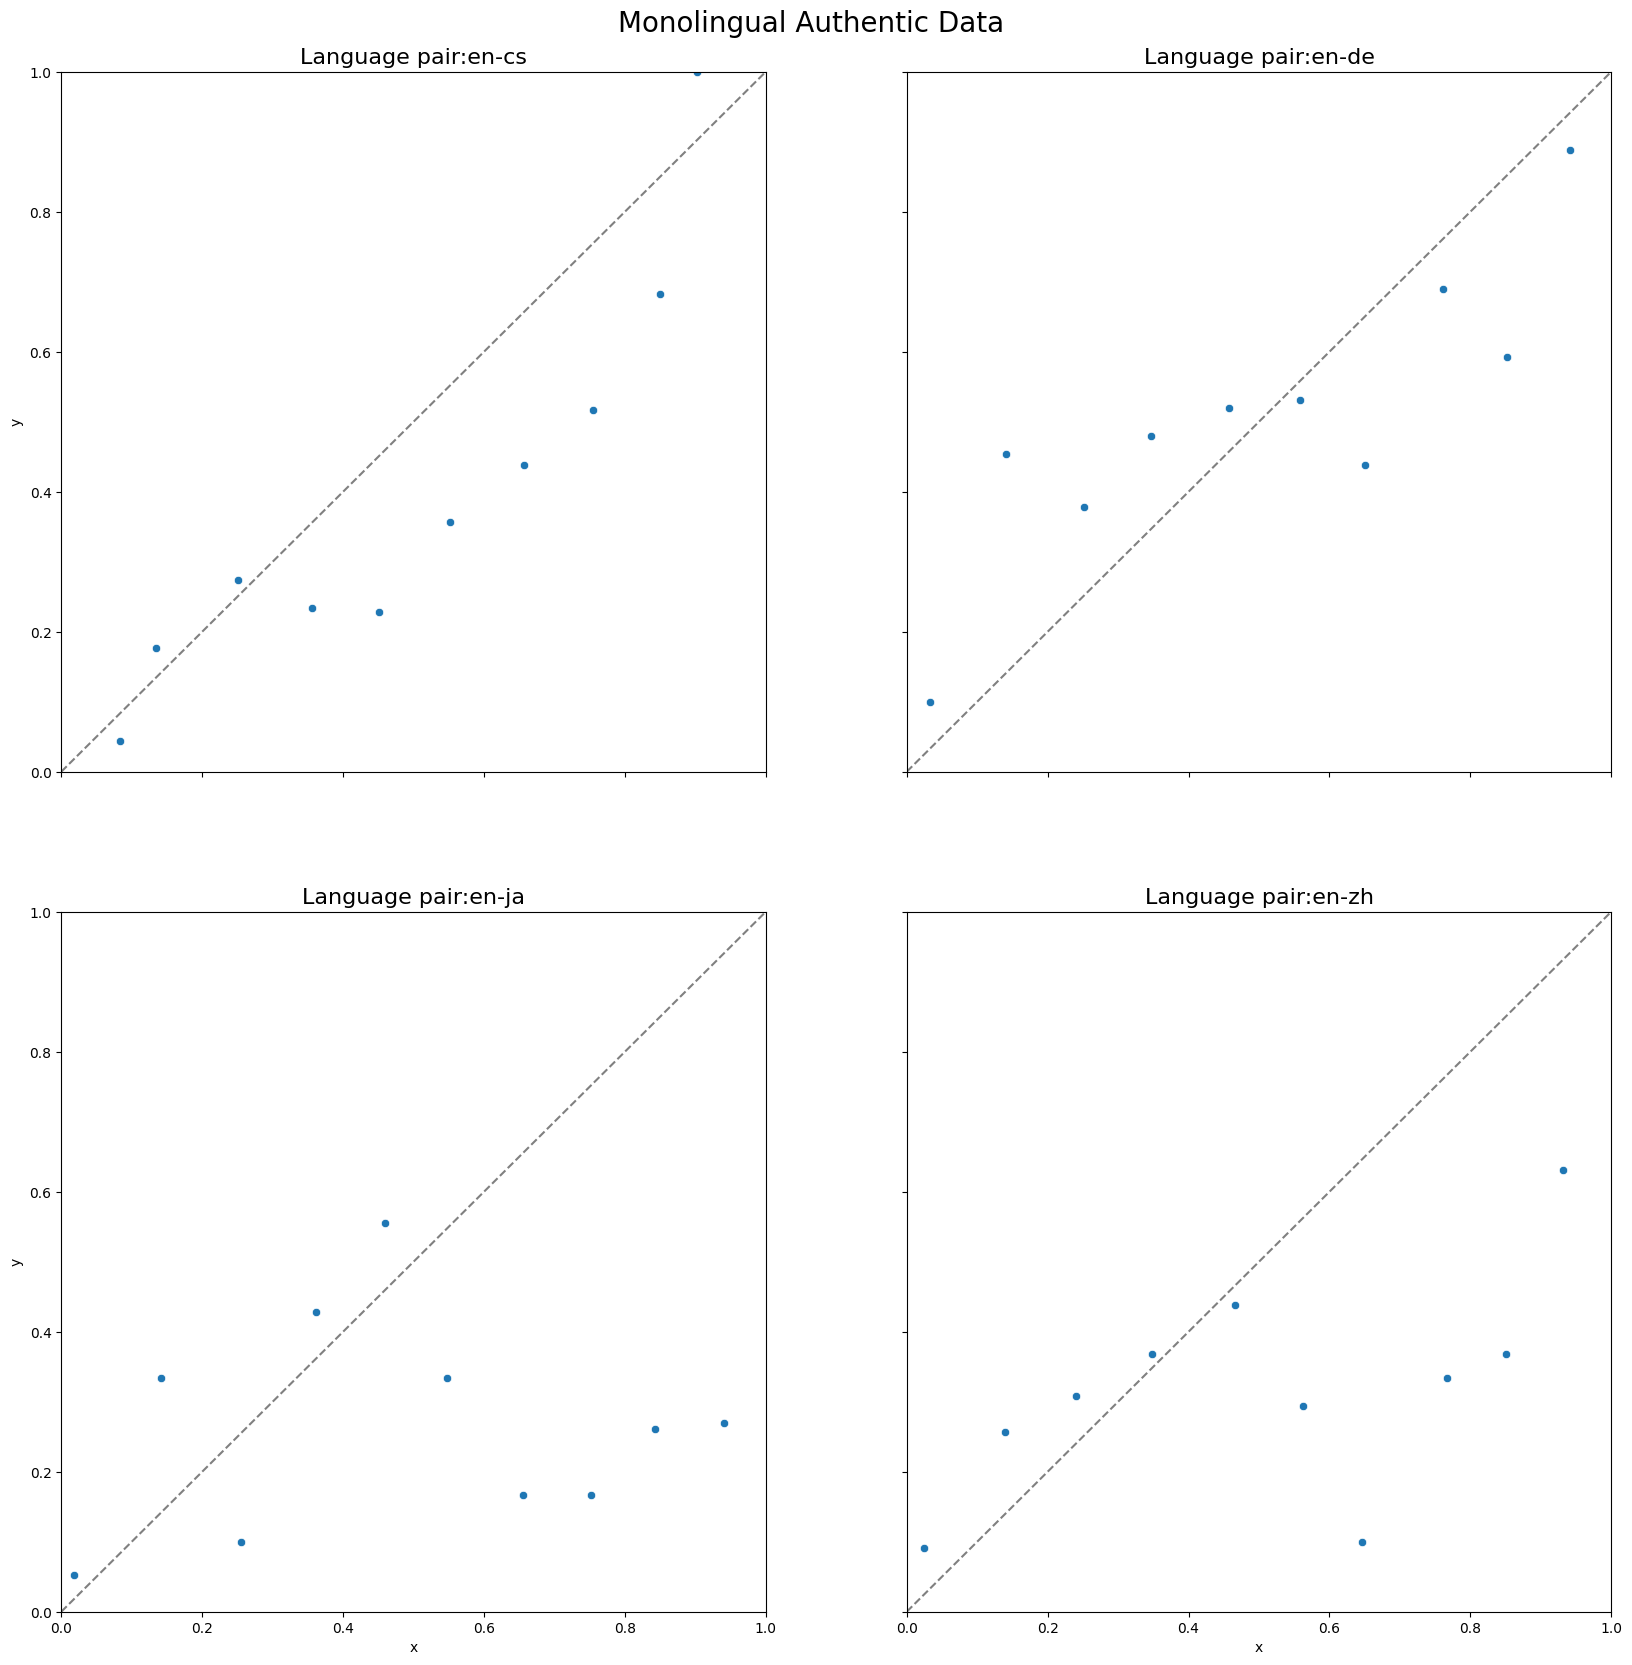

In [13]:
fig = create_calib_plot(CHART_NAME, titles, x_vals, y_vals)

In [14]:
dev_x_vals = []
dev_y_vals = []
test_x_vals = []
test_y_vals = []
calibrated_test_preds = []
for ind, _ in enumerate(preds):
    iso_reg = IsotonicRegression().fit(preds[ind], targets[ind])
    iso_preds = iso_reg.predict(preds[ind])
    y, x = calibration_curve(targets[ind], iso_preds, n_bins=10)
    dev_x_vals.append(x)
    dev_y_vals.append(y)
    df = pd.DataFrame(1-iso_preds, columns=['score'])
    df.index = indices[ind]
    df.to_csv(os.path.join(PREDICTIONS_DIR, 'ced_data', EXPERIMENT_GROUP_NAME + '_calibrated', LI_LANGUAGE_PAIRS_WMT_21_CED[ind] + '_dev_0.csv'))

    iso_test_preds = iso_reg.predict(test_preds[ind])
    calibrated_test_preds.append(iso_test_preds)
    y, x = calibration_curve(test_targets[ind], iso_test_preds, n_bins=10)
    test_x_vals.append(x)
    test_y_vals.append(y)
    df = pd.DataFrame(1-iso_test_preds, columns=['score'])
    df.index = test_indices[ind]
    df.to_csv(os.path.join(PREDICTIONS_DIR, 'ced_data', EXPERIMENT_GROUP_NAME + '_calibrated', LI_LANGUAGE_PAIRS_WMT_21_CED[ind] + '_test_0.csv'))
    

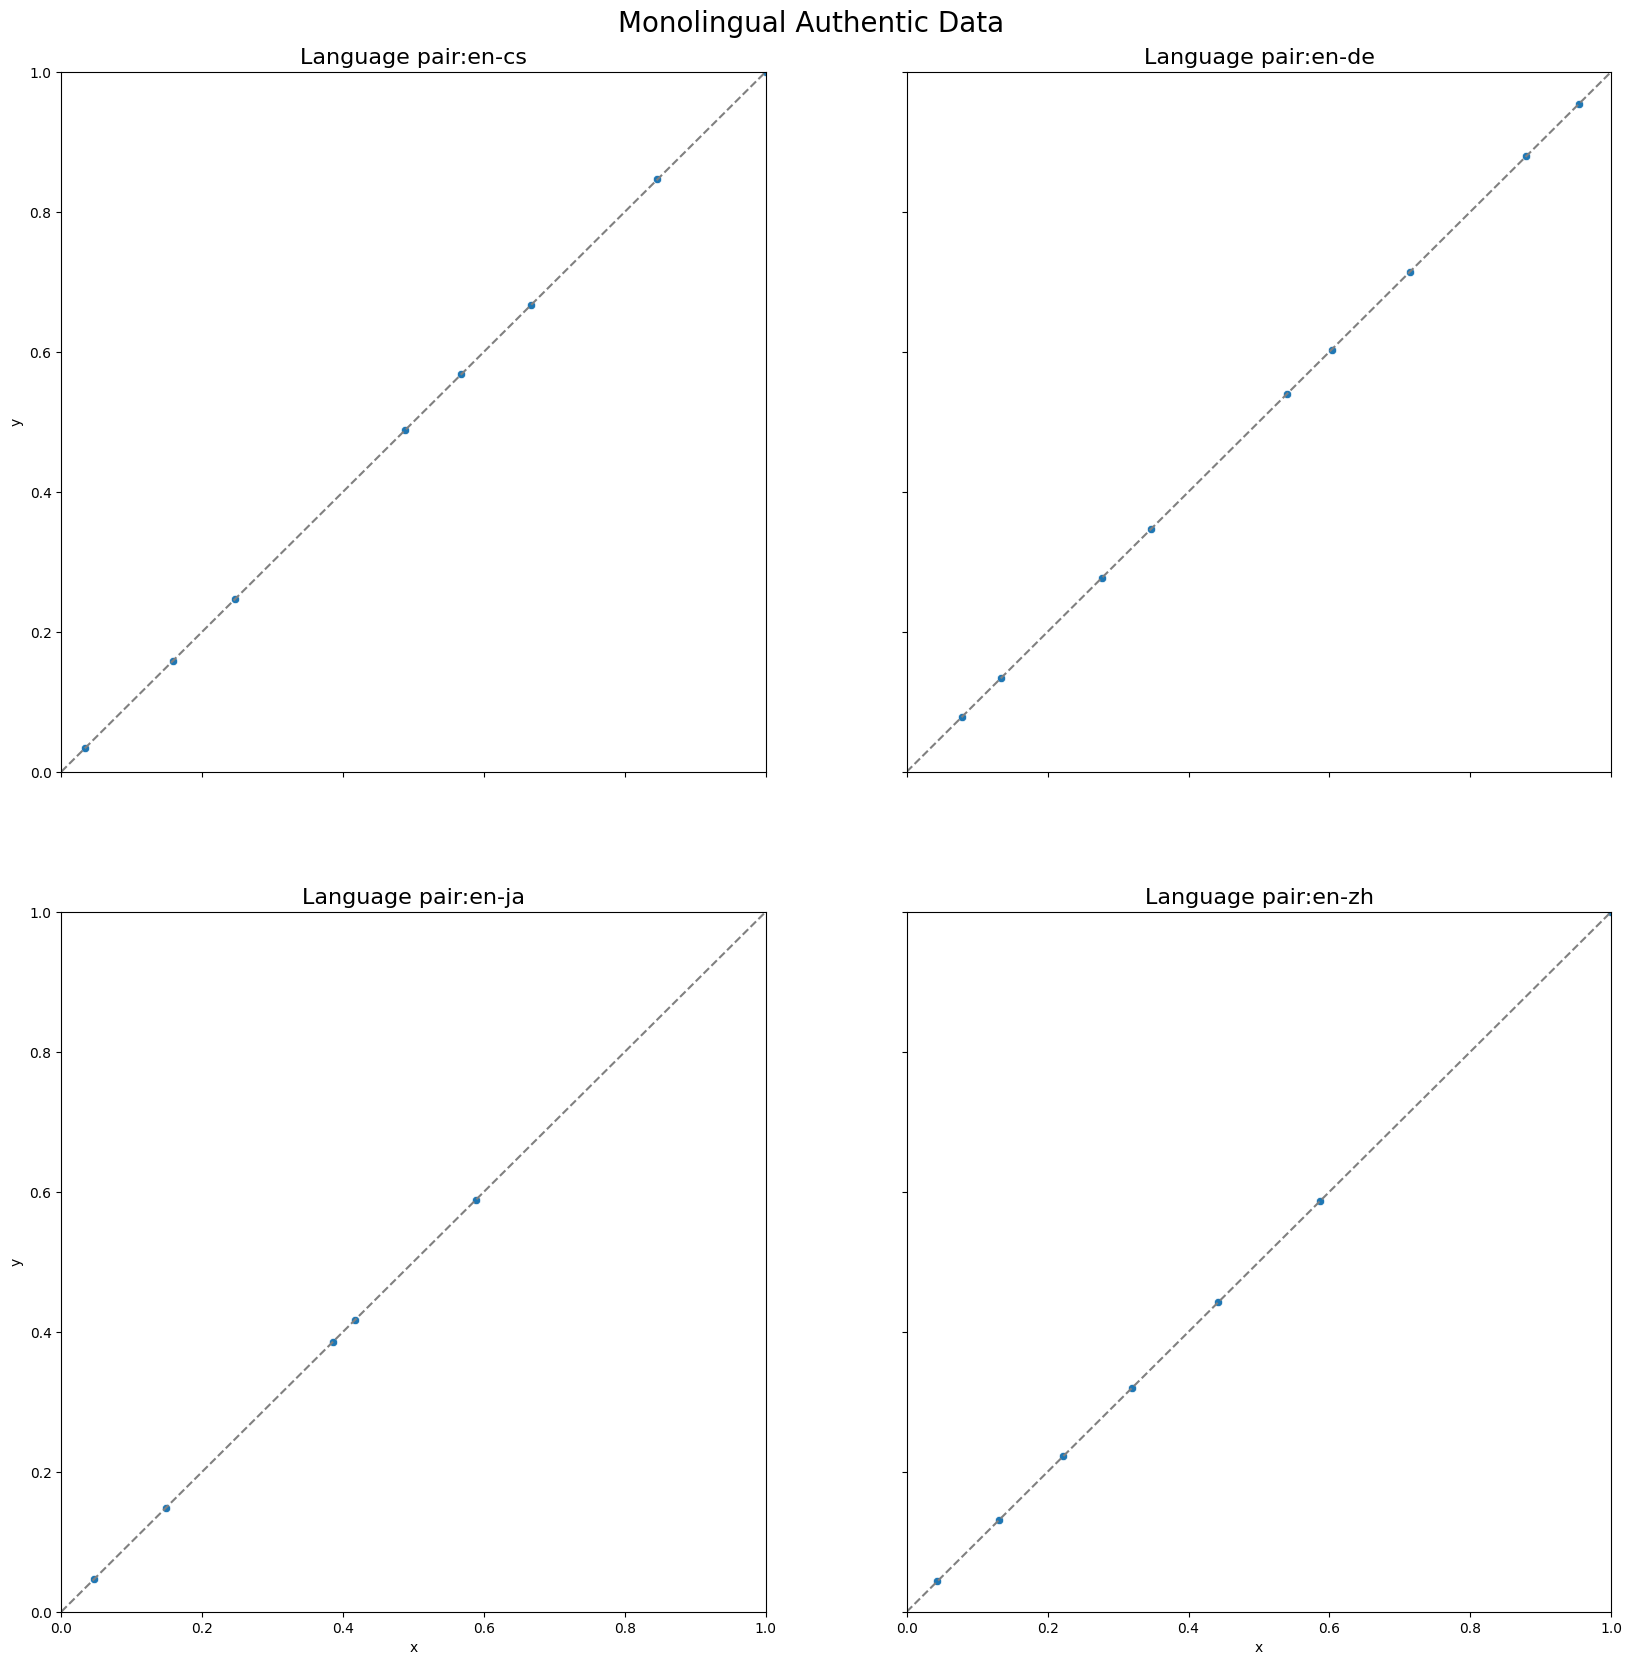

In [15]:
fig = create_calib_plot(CHART_NAME, titles, dev_x_vals, dev_y_vals)

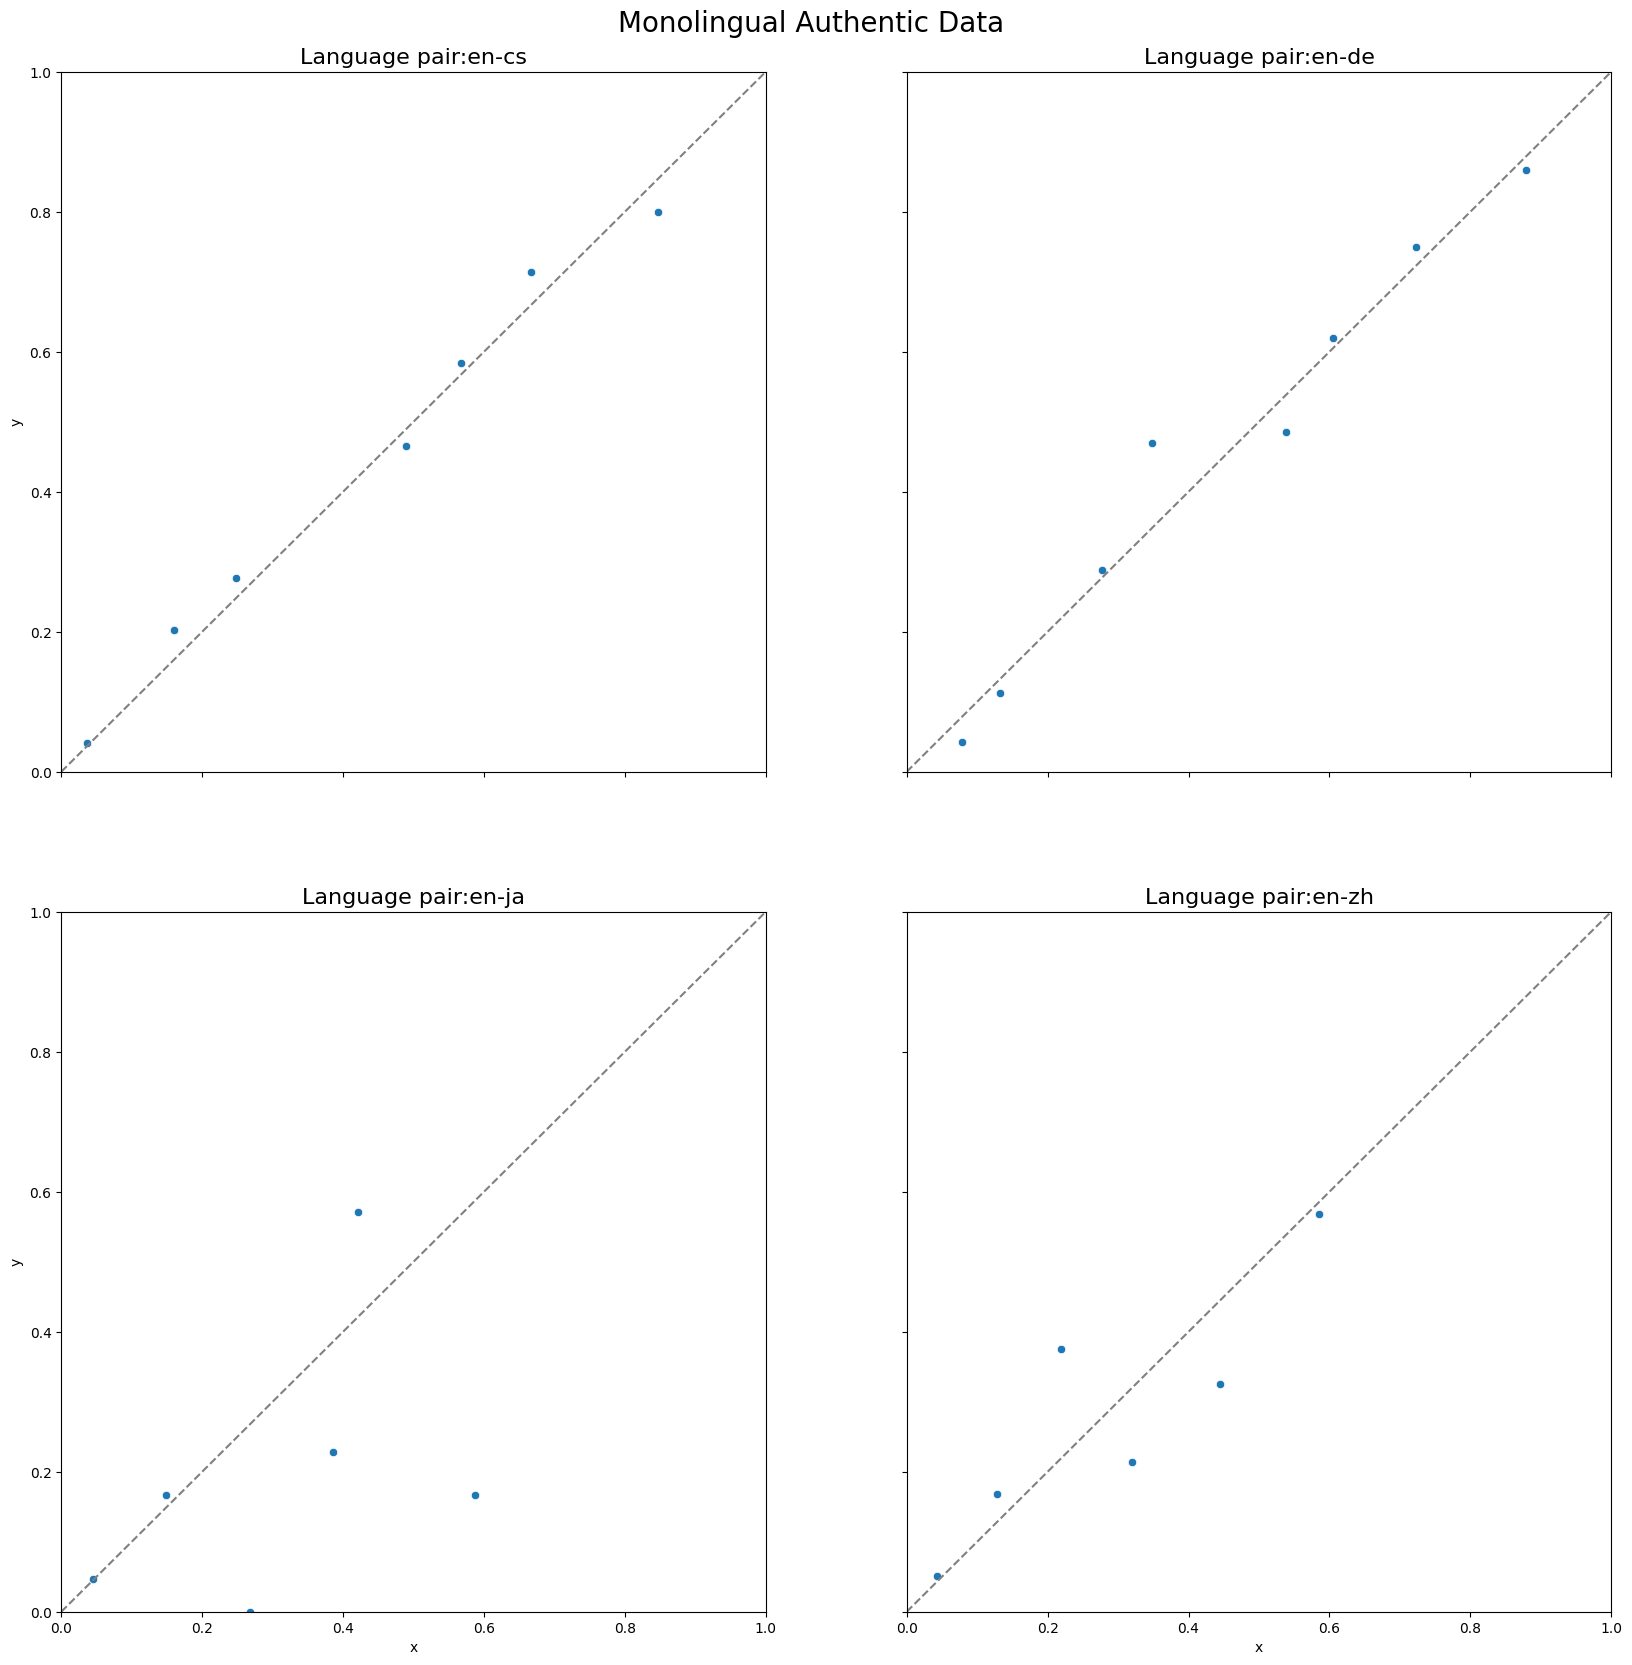

In [16]:
fig = create_calib_plot(CHART_NAME, titles, test_x_vals, test_y_vals)

In [17]:
test_x_vals[0]

array([0.0360782 , 0.16007253, 0.24769214, 0.48958702, 0.56746032,
       0.66666667, 0.84741441,        nan])

In [18]:
dev_x_vals[0]

array([0.0335097 , 0.15816327, 0.24691358, 0.48837209, 0.56756757,
       0.66666667, 0.84615385, 1.        ])

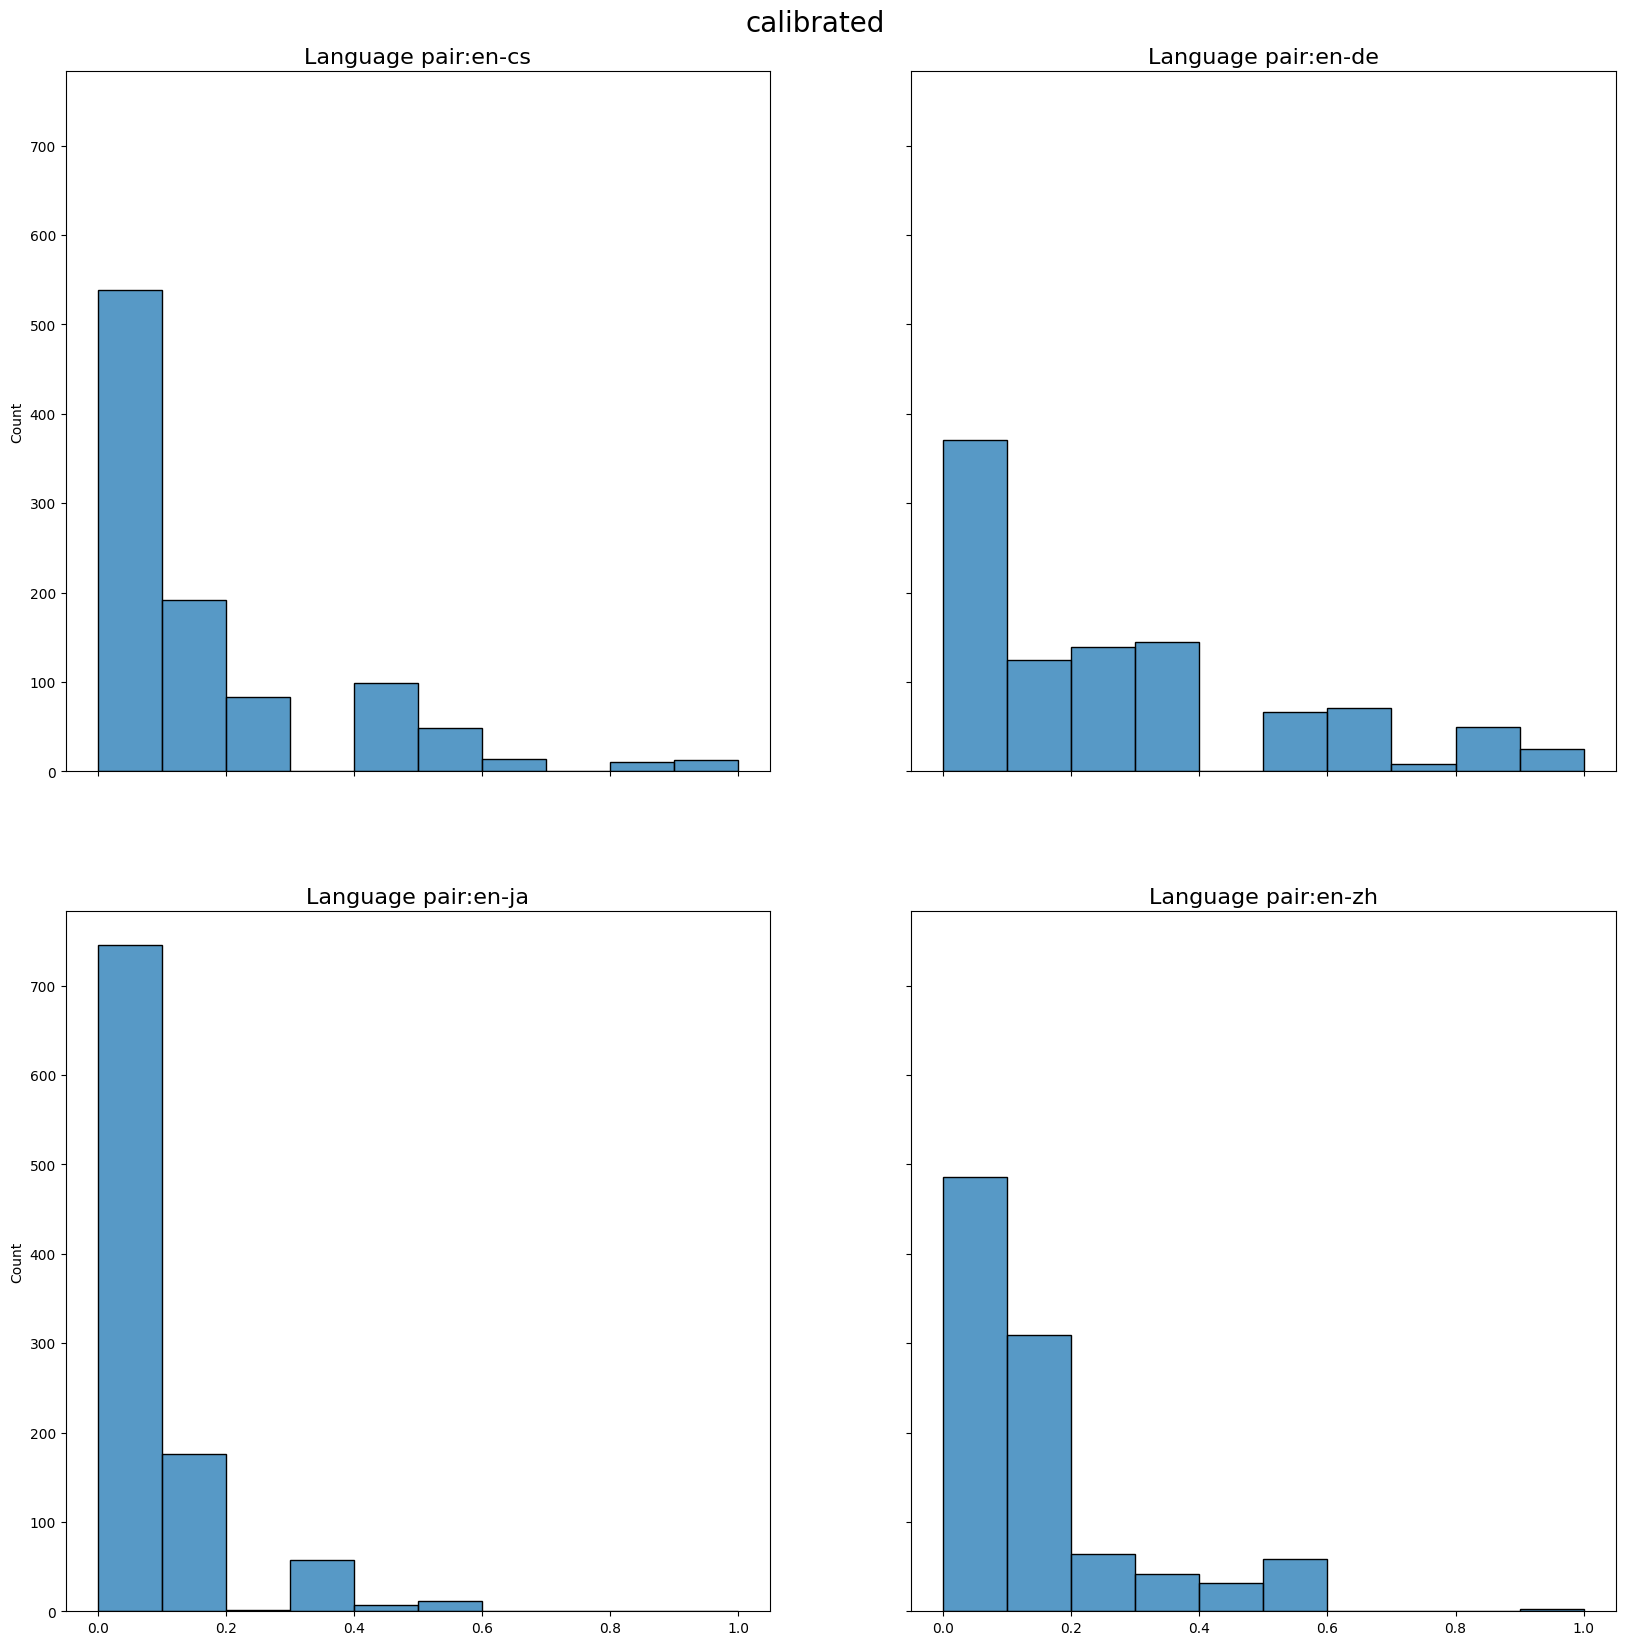

In [21]:
fig = create_histogram_plot('calibrated', titles, calibrated_test_preds)

['Language pair:en-cs',
 'Language pair:en-de',
 'Language pair:en-ja',
 'Language pair:en-zh']